In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from tqdm import tqdm
from itertools import combinations
from ml_datasets.esl import ProstateCancer

In [3]:
prostate_cancer = ProstateCancer(verbose=0)

In [4]:
df = prostate_cancer.load()

In [5]:
train_test = prostate_cancer.train_test
df_x = df[prostate_cancer.meta[:-1]]
df_y = df[prostate_cancer.meta[-1]]

In [6]:
def scale(x):
    mean = x.values.mean(axis=0, keepdims=True)
    stdev = x.values.std(axis=0, keepdims=True, ddof=0)
    return np.divide(np.subtract(x, mean), stdev)

##### Scaling

In [7]:
df_x = df_x.apply(lambda x: scale(x))

In [8]:
x_train = df_x[train_test=='T'].values
y_train =  df_y[train_test=='T'].values

x_test = df_x[train_test=='F'].values
y_test =  df_y[train_test=='F'].values

In [14]:
class LeastSquaresRegression:
    def __init__(self, *args, **kwargs):
        self.intercept = kwargs.get('intercept', True)
    
    def fit(self, x, y):
        self.y = y
        
        x = self._check_intercept(x)

        # check if dot(x.T, x) is invertible
        if self._check_condition(x) == 1:
            xtx = x.T @ x
            xtx_inv = np.linalg.inv(xtx)
            self.beta_hat = xtx_inv @ x.T @ self.y
    
    def _check_intercept(self, x):
        if self.intercept:
            if not np.isnan(x).any():
                # append intercept in the input x, so x = [1, x1, x2, ...]
                x = np.concatenate((np.ones_like(x[:, 0].reshape(-1, 1)), x), axis=1)
            else:
                # if x is nan, it means the input is just the intercept
                x = np.ones_like(x.reshape(-1, 1))
        return x
    
    def _check_condition(self, x):
        xtx = x.T @ x
        
        if np.linalg.cond(xtx) < 1/sys.float_info.epsilon:
            xtx_inv = np.linalg.inv(xtx)
            return 1
        
        else:
            print("dot(x.T, x) is ill-conditioned")
            sys.exit()
        
    def calculate_z(self, x, y):
        # use (1 / (x.shape[0] - x.shape[1])) instead of (1 / (x.shape[0] - x.shape[1] - 1))
        # since it already includes the intercept
        x = self._check_intercept(x)
        
        if self._check_condition(x) == 1:
            xtx = x.T @ x
            xtx_inv = np.linalg.inv(xtx)
        
        self.variance_hat = (1 / (x.shape[0] - x.shape[1])) * np.sum((y - x @ self.beta_hat) ** 2)
        self.beta_hat_var = np.sqrt(np.diag(xtx_inv) * self.variance_hat)
        self.z = self.beta_hat / self.beta_hat_var
        
    def predict(self, x):
        x = self._check_intercept(x)
        return x @ self.beta_hat
    
    def calculate_f(self, x, y, x0):
        x = self._check_intercept(x)
        rss1 = self.RSS(x, y)
        rss1 = np.sum((y - x @ self.beta_hat) ** 2)
        
        x0 = self._check_intercept(x0)
        if self._check_condition(x) == 1:
            xtx0 = x0.T @ x0
            xtx0_inv = np.linalg.inv(xtx0)
            beta_hat_0 = xtx0_inv @ x0.T @ self.y
        
        rss0 = self.RSS(x, y, beta_hat=beta_hat_0)

        self.F = ((rss0 - rss1) / (x.shape[1] - x0.shape[1])) / (rss1/ (len(y) - x.shape[1]))
        self.dfn = (x.shape[1] - x0.shape[1])
        self.dfd = (x.shape[0] - x.shape[1])
        self.p_value = 1 - scipy.stats.f.cdf(self.F, dfn=self.dfn, dfd=self.dfd)
        
    def RSS(self, x, y, beta_hat=None):
        
        if beta_hat is None:
            beta_hat = self.beta_hat
            
        x = self._check_intercept(x)
        y_hat = x @ beta_hat
        return (y - y_hat).T @ (y - y_hat)

training on subsets: 100%|███████████████████████████████████████████████████████████████| 8/8 [00:00<00:00,  9.51it/s]


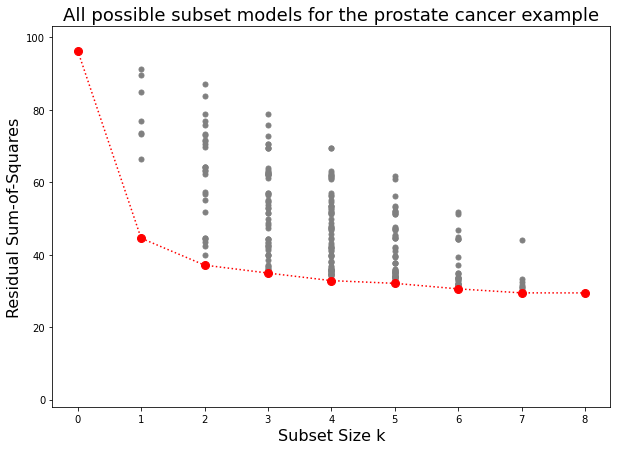

In [16]:
subsets = np.arange(1, x_train.shape[1] + 1)
x_train_temp = np.array(np.nan * x_train[:, 1])

lsreg = LeastSquaresRegression()
lsreg.fit(x_train_temp, y_train)

x_test_temp = np.array(np.nan * x_test[:, 1])
y_hat_temp = lsreg.predict(x_train_temp)

best_subset = dict()
best_subset[0] = lsreg.RSS(x_train_temp, y_train)

plt.figure(figsize=(10, 7))
plt.title('All possible subset models for the prostate cancer example', fontsize=18)
for i, subset in enumerate(tqdm(subsets, total=len(subsets), desc="training on subsets")):
    subset = list(combinations(subsets, subset))
    best_RSS = 100
    
    for idxs in subset:
        x_train_temp = x_train[:, np.array(idxs) - 1]
        lsreg = LeastSquaresRegression()
        lsreg.fit(x_train_temp, y_train)
        RSS_temp = lsreg.RSS(x_train_temp, y_train)
        
        if RSS_temp < best_RSS:
            best_subset[i + 1] = RSS_temp
            best_RSS = RSS_temp
        plt.plot(len(np.array(idxs)), RSS_temp, 'o', color='grey', markersize=5)

best_subset_k = list(best_subset.keys())
best_subset_RSS = list(best_subset.values())

plt.plot(best_subset_k, best_subset_RSS, 'r:o', markersize=8, mfc='red')
plt.ylim([-2, 103])
plt.xlabel('Subset Size k', fontsize=16)
plt.ylabel('Residual Sum-of-Squares', rotation=90, fontsize=16)
plt.show()